In [1]:
import os

# Dask Configuration

In [2]:
from dask_jobqueue import PBSCluster
from pathlib import Path

# Define the working directory path
working_directory = str(Path.cwd())

# Launch a scheduler and workers on HPC via PBS
cluster = PBSCluster(
     cores=4,
     memory="8GB",
     processes=1,
     queue="tamirQ",
     walltime="02:30:00",
     scheduler_options={"dashboard_address": ":12435"},  # FIXME - this is the port we need to define...
     # Additional custom options
     log_directory="dask-logs",
     #worker_extra_args=["--lifetime", "25m", "--lifetime-stagger", "4m"],  # for walltime="00:30:00"
     job_script_prologue=[f"cd {working_directory}"]
)

In [3]:
cluster

Dashboard: http://132.66.112.146:12435/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://132.66.112.146:44929,Workers: 0
Dashboard: http://132.66.112.146:12435/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
cluster.adapt(minimum=30, maximum=60)
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q tamirQ
#PBS -l select=1:ncpus=4:mem=7630MB
#PBS -l walltime=02:30:00
#PBS -e dask-logs/
#PBS -o dask-logs/
cd /tamir2/moranb/microbiome/Igem_TAU_2021
/tamir2/moranb/microbiome/Igem_TAU_2021/venv/bin/python -m distributed.cli.dask_worker tcp://132.66.112.146:44929 --nthreads 4 --memory-limit 7.45GiB --name dummy-name --nanny --death-timeout 60



In [5]:
from dask.distributed import Client, progress, wait, get_client, get_worker
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://132.66.112.146:12435/status,
Dashboard: http://132.66.112.146:12435/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://132.66.112.146:44929,Workers: 0
Dashboard: http://132.66.112.146:12435/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
import dask.bag as db
import dask.dataframe as dd
from dask import delayed, compute, persist
from pandas.core.dtypes.common import pandas_dtype as dtype
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path

/tamir2/moranb/microbiome/Igem_TAU_2021/venv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Analysis for homo sapiens genes

In [8]:
import operator
from Bio import SeqIO
from analysis.orf_model_analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data
from analysis.orf_model_analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus

from modules.main import run_modules
from modules.user_IO.input_functions import extract_gene_data

In [23]:
output_path = "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens"
optimization_cub_index = "CAI"

variant_names = [
    "{score}_single_diff",
    "{score}_zscore_single_diff",
    "{score}_zscore_bulk_diff",
    "{score}_single_ratio",
    "{score}_zscore_single_ratio",
    "{score}_zscore_bulk_ratio",
]

average_distance_variant_names = [s.format(score="average_distance_score") for s in variant_names]

In [10]:
def get_configuration(is_ecoli_optimized):
    return f"e_coli_optimized_{is_ecoli_optimized}_bacillus_optimized_{not is_ecoli_optimized}"

In [11]:
def get_df_for_run_configuration(configuration, optimization_method, is_debug=False):
    configuration_output_path = os.path.join(output_path, configuration)
    debug_suffix = '-debug' if is_debug else ''
    results_dir = F"{os.path.join(configuration_output_path, optimization_method + debug_suffix)}"
    bag = db.read_text([str(file) for file in list(Path(results_dir).rglob("*.json"))]).map(json.loads)
    
    error_records = bag.filter(lambda x: "error_message" in x.keys())
    valid_records = bag.filter(lambda x: "error_message" not in x.keys())
    
    return valid_records.to_dataframe().compute(), error_records.compute()
    
    # return dd.read_json([str(file) for file in list(Path(results_dir).rglob("*.json"))], orient='records', lines=True)

In [12]:
def get_scores_df_by_configuration(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)
    merged_bulk_zscore_df = dd.merge(df_bulk_zscore_ratio, df_bulk_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_bulk_ratio', '_zscore_bulk_diff'))

    df_single_zscore_ratio, df_single_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_ratio", is_debug)
    df_single_zscore_diff, df_single_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_diff", is_debug)
    merged_single_zscore_df = dd.merge(df_single_zscore_ratio, df_single_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_single_ratio', '_zscore_single_diff'))

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)
    merged_single_df = dd.merge(df_single_codon_ratio, df_single_codon_diff, on='gene_name', how='inner', suffixes=('_single_ratio', '_single_diff'))

    merged_df = dd.merge(merged_bulk_zscore_df, merged_single_zscore_df, on='gene_name', how='inner')
    merged_df = dd.merge(merged_df, merged_single_df, on='gene_name', how='inner')
    return merged_df, [df_bulk_zscore_ratio_errors, df_bulk_zscore_diff_errors, df_single_zscore_ratio_errors, df_single_zscore_diff_errors, df_single_codon_ratio_error, df_single_codon_diff_error]

In [13]:
def add_median_to_histogram(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-1, upper_limit, f"median={median_value}")

In [14]:
def add_median_to_histogram_non_normalized(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-0.1, upper_limit, f"median={median_value}")

In [59]:
def plot_comparative_graphs(result):
    figure, axis = plt.subplots(8, 2, figsize=(20,35))

    index = 0
    for i, first_variant in enumerate(average_distance_variant_names):
        for j, second_variant in enumerate(average_distance_variant_names):
            if j <= i:
                continue 
            scatter = result.plot.scatter(x=first_variant, y=second_variant, ax=axis[index//2, index%2])
            r, p = stats.pearsonr(result[first_variant], result[second_variant])
            scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
            index += 1

#### Escherichia-coli as wanted host 

In [16]:
configuration = get_configuration(is_ecoli_optimized=False)
   
result, errors = get_scores_df_by_configuration(configuration)

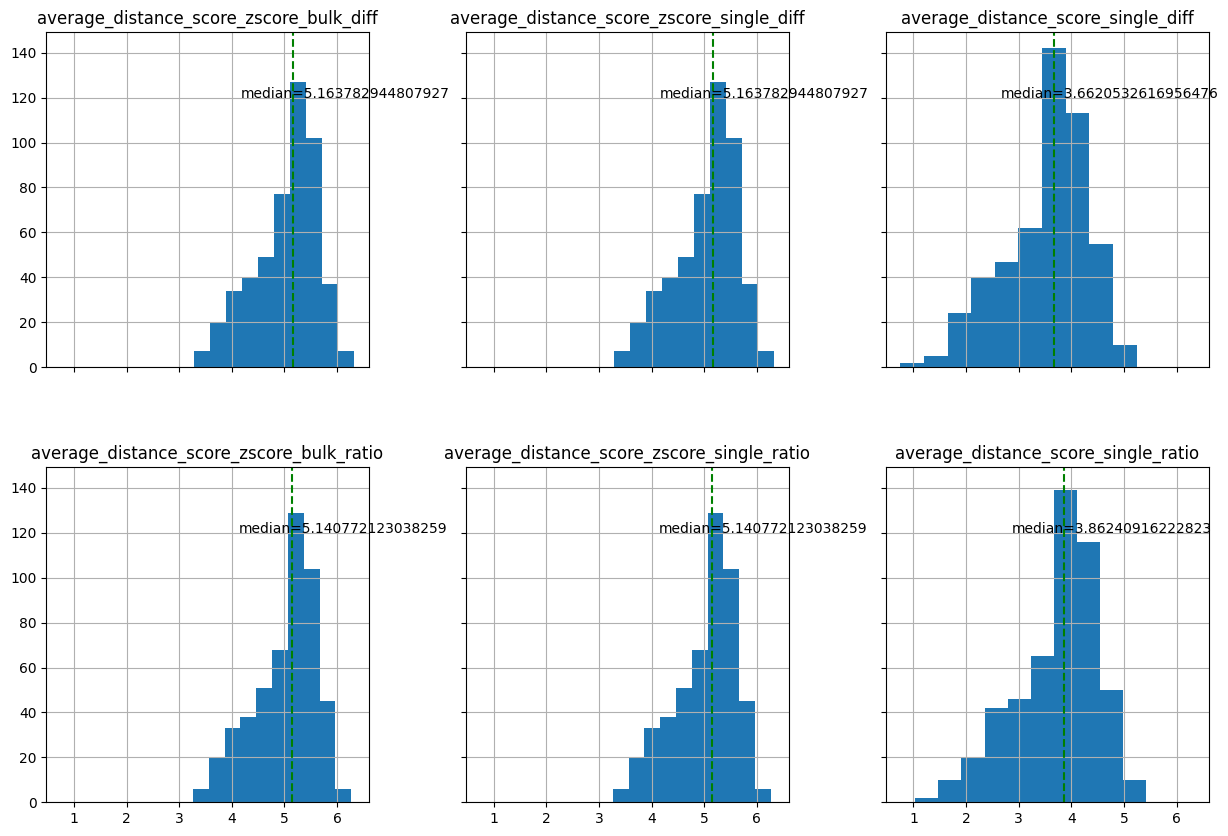

In [17]:
histogram = result[["average_distance_score_zscore_bulk_diff", "average_distance_score_zscore_single_diff", "average_distance_score_single_diff", "average_distance_score_zscore_bulk_ratio", "average_distance_score_zscore_single_ratio", "average_distance_score_single_ratio"]].hist(sharex=True, sharey=True,figsize=(15, 10), layout=(2,3))

median_height = 120
add_median_to_histogram(result["average_distance_score_zscore_bulk_diff"], histogram, 0, 0, median_height)
add_median_to_histogram(result["average_distance_score_zscore_single_diff"], histogram, 0, 1, median_height)
add_median_to_histogram(result["average_distance_score_single_diff"], histogram, 0, 2, median_height)

add_median_to_histogram(result["average_distance_score_zscore_bulk_ratio"], histogram, 1, 0, median_height)
add_median_to_histogram(result["average_distance_score_zscore_single_ratio"], histogram, 1, 1, median_height)
add_median_to_histogram(result["average_distance_score_single_ratio"], histogram, 1,2, median_height)

In [18]:
single_diff_negative = result[result["average_distance_score_single_diff"] < 0] 
single_ratio_negative = result[result["average_distance_score_single_ratio"] < 0] 

zscore_bulk_diff_negative = result[result["average_distance_score_zscore_bulk_diff"] < 0] 
zscore_bulk_ratio_negative = result[result["average_distance_score_zscore_bulk_ratio"] < 0]

zscore_single_diff_negative = result[result["average_distance_score_zscore_single_diff"] < 0] 
zscore_single_ratio_negative = result[result["average_distance_score_zscore_single_ratio"] < 0] 

print(f"{len(single_diff_negative)}, percentage:{len(single_diff_negative)/len(result) * 100}")
print(f"{len(single_ratio_negative)}, percentage:{len(single_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_bulk_diff_negative)}, percentage:{len(zscore_bulk_diff_negative)/len(result) * 100}")
print(f"{len(zscore_bulk_ratio_negative)}, percentage:{len(zscore_bulk_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_single_diff_negative)}, percentage:{len(zscore_single_diff_negative)/len(result) * 100}")
print(f"{len(zscore_single_ratio_negative)}, percentage:{len(zscore_single_ratio_negative)/len(result) * 100}")

0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0


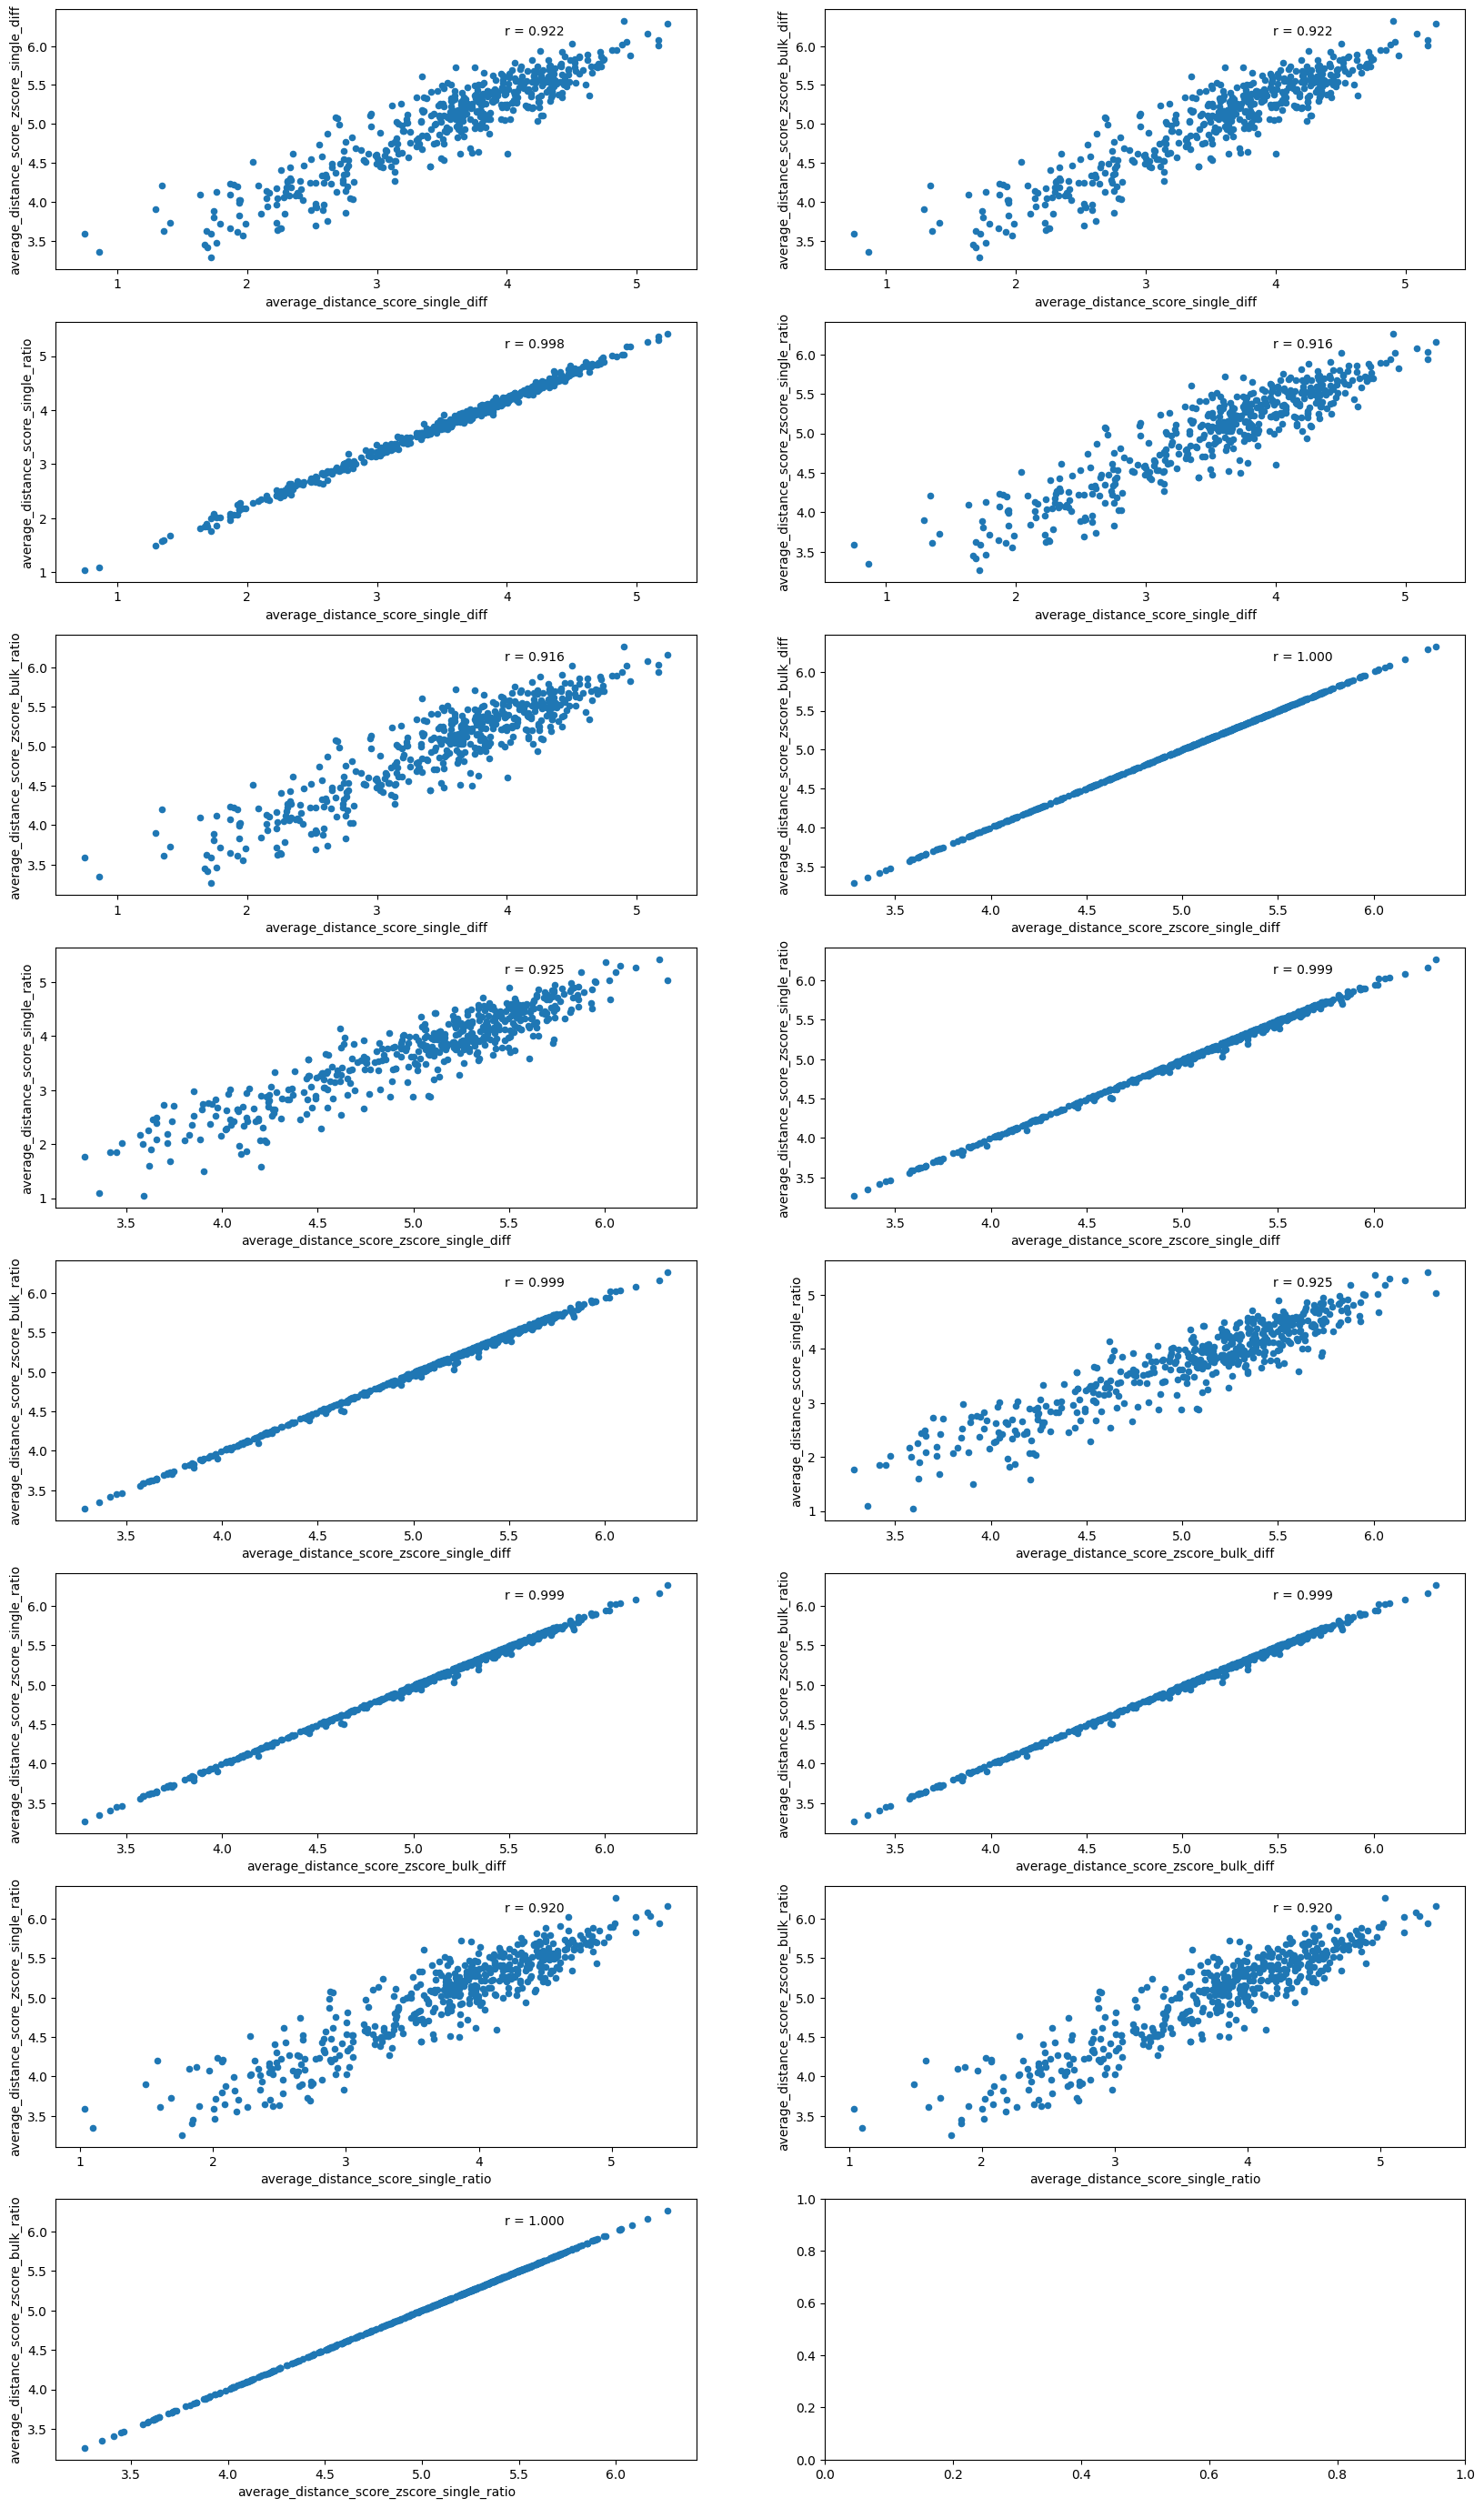

Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

In [60]:
plot_comparative_graphs(result)

#### Escherichia-coli as unwanted host 

In [ ]:
configuration = "e_coli_optimized_False_bacillus_optimized_True"
result = get_scores_df_for_organism_by_configuration(configuration, organism)
result = result.compute()

In [ ]:
histogram = result[["average_distance_score_zscore_diff",  "average_distance_score_single_diff", "average_distance_score_zscore_ratio", "average_distance_score_single_ratio"]].hist(sharex=True, sharey=True,figsize=(10, 9))

add_median_to_histogram(result["average_distance_score_zscore_diff"], histogram, 0, 0, 1800)
add_median_to_histogram(result["average_distance_score_single_diff"], histogram, 0, 1, 1800)
add_median_to_histogram(result["average_distance_score_zscore_ratio"], histogram, 1, 0, 1800)
add_median_to_histogram(result["average_distance_score_single_ratio"], histogram, 1, 1, 1800)

In [ ]:
single_diff_negative = result[result["average_distance_score_single_diff"] < 0] 
single_ratio_negative = result[result["average_distance_score_single_ratio"] < 0] 

zscore_diff_negative = result[result["average_distance_score_zscore_diff"] < 0] 
zscore_ratio_negative = result[result["average_distance_score_zscore_ratio"] < 0] 

merged_negative = dd.merge(single_ratio_negative, single_ratio_negative, on='gene_name', how='inner', suffixes=('_neg_ratio', '_neg_diff'))

print(f"{len(single_diff_negative)}, percentage:{len(single_diff_negative)/len(result) * 100}")
print(f"{len(single_ratio_negative)}, percentage:{len(single_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_diff_negative)}, percentage:{len(zscore_diff_negative)/len(result) * 100}")
print(f"{len(zscore_ratio_negative)}, percentage:{len(zscore_ratio_negative)/len(result) * 100}")

# single_ratio_negative["gene_name"]

In [ ]:
plot_comparative_graphs(result)

In [ ]:
configuration = "e_coli_optimized_False_bacillus_optimized_True"
result = get_scores_df_for_organism_by_configuration(configuration, organism, is_debug=True)
result = result.compute()

In [ ]:
histogram = result[["average_distance_non_normalized_score_zscore_diff",  "average_distance_non_normalized_score_single_diff", "average_distance_non_normalized_score_zscore_ratio", "average_distance_non_normalized_score_single_ratio"]].hist(sharex=True, sharey=True,figsize=(15, 10))

add_median_to_histogram_non_normalized(result["average_distance_non_normalized_score_zscore_diff"], histogram, 0, 0, 1800)
add_median_to_histogram_non_normalized(result["average_distance_non_normalized_score_single_diff"], histogram, 0, 1, 1800)
add_median_to_histogram_non_normalized(result["average_distance_non_normalized_score_zscore_ratio"], histogram, 1, 0, 1800)
add_median_to_histogram_non_normalized(result["average_distance_non_normalized_score_single_ratio"], histogram, 1, 1, 1800)

In [ ]:
single_diff_negative = result[result["average_distance_non_normalized_score_single_diff"] < 0] 
single_ratio_negative = result[result["average_distance_non_normalized_score_single_ratio"] < 0] 

zscore_diff_negative = result[result["average_distance_non_normalized_score_zscore_diff"] < 0] 
zscore_ratio_negative = result[result["average_distance_non_normalized_score_zscore_ratio"] < 0] 

merged_negative = dd.merge(single_ratio_negative, single_ratio_negative, on='gene_name', how='inner', suffixes=('_neg_ratio', '_neg_diff'))

print(f"{len(single_diff_negative)}, percentage:{len(single_diff_negative)/len(result) * 100}")
print(f"{len(single_ratio_negative)}, percentage:{len(single_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_diff_negative)}, percentage:{len(zscore_diff_negative)/len(result) * 100}")
print(f"{len(zscore_ratio_negative)}, percentage:{len(zscore_ratio_negative)/len(result) * 100}")